# Import library

In [1]:
import cv2
import os
import torch
import dagshub
import datetime
import mlflow
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from roboflow import Roboflow
from ultralytics import YOLO, solutions, settings

%matplotlib inline

# Setup dagshub

In [2]:
# ML Flow dan DagsHub Integration
dagshub.init(repo_owner='abiyamf', repo_name='visiKomputerFundamental', mlflow=True)
settings.update({"mlflow": True})

Accessing as abiyamf

Initialized MLflow to track repo "abiyamf/visiKomputerFundamental"

Repository abiyamf/visiKomputerFundamental initialized!

In [3]:
os.environ["MLFLOW_KEEP_RUN_ACTIVE"] = "True"
gpu_name = torch.cuda.get_device_name(0)

def format_duration(seconds: float) -> str:
    """Convert seconds into 'Hh Mm Ss' format."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours}h {minutes}m {secs}s"

def save_class_metrics(val_results, mode):
    # Ambil nama class
    names = val_results.names

    # Data per-class
    data = {
        "class": [names[i] for i in range(len(names))],
        "precision": val_results.box.p.tolist(),
        "recall": val_results.box.r.tolist(),
        "mAP50": val_results.box.ap50.tolist(),
        "mAP50-95": val_results.box.maps.tolist(),
    }

    # Tambahkan baris agregat "all"
    all_row = {
        "class": "all",
        "precision": float(val_results.box.mp),
        "recall": float(val_results.box.mr),
        "mAP50": float(val_results.box.map50),
        "mAP50-95": float(val_results.box.map),
    }

    for key in data.keys():
        data[key].insert(0, all_row[key])

    # Buat DataFrame dan simpan
    df = pd.DataFrame(data)
    csv_path = os.path.join(str(val_results.save_dir), f"class_metrics_{mode}.csv")
    df.to_csv(csv_path, index=False)

    return csv_path

# Download dataset

In [ ]:
# Dataset 3 class with augmentation brightness
rf = Roboflow(api_key="XufIgI94wgR9n3u7GKJT")
project = rf.workspace("abiyamf").project("green-coffee-bean-defects-npvzu")
version = project.version(5)
dataset = version.download("yolov12", location="dataset_collection/3class_augmentation_brightness")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dataset_collection/3class_augmentation_brightness in yolov12:: 100%|██████████| 3460/3460 [00:01<00:00, 2034.44it/s]


In [4]:
# Dataset 3 class with augmentation brightness, rotation, flip
rf = Roboflow(api_key="XufIgI94wgR9n3u7GKJT")
project = rf.workspace("abiyamf").project("green-coffee-bean-defects-npvzu")
version = project.version(7)
dataset = version.download("yolov12", location="dataset_collection/3class_augmentation_brightness_rotation_flip")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dataset_collection/3class_augmentation_brightness_rotation_flip in yolov12:: 100%|██████████| 3460/3460 [00:02<00:00, 1668.54it/s]


In [13]:
# Dataset 3 class without augmentation
rf = Roboflow(api_key="XufIgI94wgR9n3u7GKJT")
project = rf.workspace("abiyamf").project("green-coffee-bean-defects-npvzu")
version = project.version(6)
dataset = version.download("yolov12", location="dataset_collection/3class_without_augmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dataset_collection/3class_without_augmentation in yolov12:: 100%|██████████| 2016/2016 [00:01<00:00, 1153.22it/s]


# Training - searching best YOLO version from (v8 - v12)

In [ ]:
# Variabel Global
projectType = "yolo_version_comparison_experiment"
imgsz = 640
models = ['yolov8m.pt', 'yolov9m.pt', 'yolov10m.pt', 'yolo11m.pt', 'yolo12m.pt']
sizes = ['medium', 'medium', 'medium', 'medium', 'medium']
epochs = 50
batch = 16
data_path_objectDetection_all_class = "dataset_collection/3class_without_augmentation"
project_base_objectDetection_all_class = "results/yolo_version_comparison_experiment"

In [5]:
mlflow.set_experiment(f"visiKomputerFundamental-{projectType}")
for model_name, size in zip(models, sizes):
    time_now = datetime.datetime.now().strftime("%d-%m_%H:%M:%S")
    model = YOLO(model_name)

    with mlflow.start_run(run_name=f"{time_now}"):

        # Log global parameters
        mlflow.log_params({
            "project type": projectType,
            "gpu": gpu_name,
            "epochs": epochs,
            "batch": batch,
            "imgsz": imgsz,
        })

        # Train the model
        start_time = time.time()
        training = model.train(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            epochs=epochs, 
            imgsz=imgsz, 
            batch=batch, 
            project=f"{project_base_objectDetection_all_class}/training", 
            name=f"{model_name}-{size}",
            exist_ok=True
        )
        end_time = time.time()

        # Validate the model
        validation = model.val(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            imgsz=imgsz,
            project=f"{project_base_objectDetection_all_class}/validation",
            name=f"{model_name}-{size}",
            exist_ok=True,
            split="test"
        )

        csv_filename = f"{project_base_objectDetection_all_class}/validation/summary/{model_name}-{size}-validation-metrics.csv"
        os.makedirs(os.path.dirname(csv_filename), exist_ok=True)
        with open(csv_filename, "w") as f:
            f.write(validation.to_csv())

        # Run validation + log class metrics
        mlflow.log_artifact(save_class_metrics(training, "training"), artifact_path="class_metrics")
        mlflow.log_artifact(save_class_metrics(validation, "validation"), artifact_path="class_metrics")

        # Log training time
        mlflow.log_params({
            "training time": format_duration(end_time - start_time),
        })

        mlflow.log_metrics({
            "val mAP50": float(validation.box.map50),
            "val mAP50-95": float(validation.box.map),
        })

        print(f"Finished training and validating {size} model.")

mlflow.end_run()

New https://pypi.org/project/ultralytics/8.3.246 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.243  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_collection/3class_without_augmentation/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False

2026/01/02 17:51:17 INFO mlflow.tracking.fluent: Experiment with name 'results/3class_without_augmentation/training' does not exist. Creating a new experiment.


MLflow: logging run_id(76c0f736d5da4823997caede6cc6f5a7) to https://dagshub.com/abiyamf/visiKomputerFundamental.mlflow
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\abiyamf\Documents\Code Program\TelU-Tubes-VisiKomputerFundamental-AnomaliDetection\results\3class_without_augmentation\training\yolov8m.pt-medium
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      6.62G      1.371      3.776      0.935         10        640: 100% ━━━━━━━━━━━━ 46/46 2.1it/s 21.5s0.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.5it/s 1.9s1.2s
                   all         80        310       0.48      0.553      0.501      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      7.58G      1.105      1.423     0.8445          8

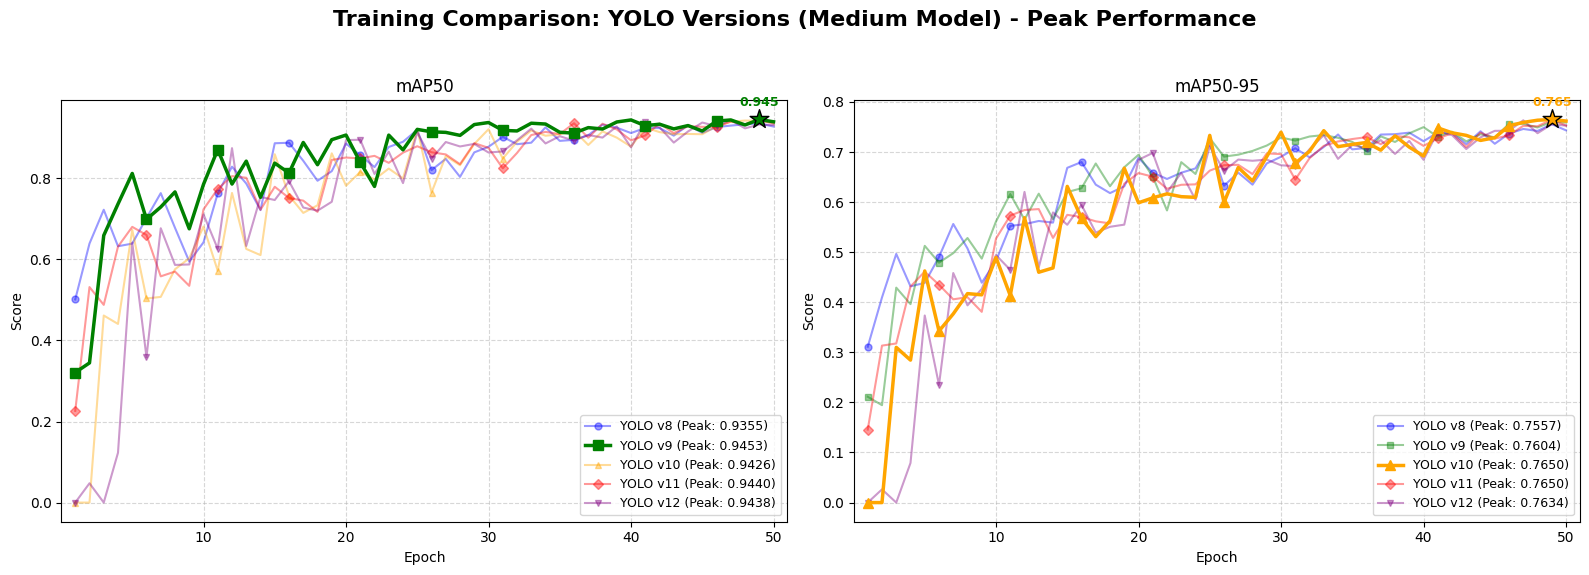

In [11]:
# --- 1. KONFIGURASI ---
# Path dasar sesuai output training Anda
base_path = Path("results/3class_without_augmentation")
training_path = base_path / "training"

# Model list sesuai kode training Anda
models = ['yolov8m.pt', 'yolov9m.pt', 'yolov10m.pt', 'yolo11m.pt', 'yolo12m.pt']
fixed_size = "medium"

# Map Metrik Ultralytics (Box Detection)
metric_map = {
    "mAP50": "metrics/mAP50(B)",
    "mAP50-95": "metrics/mAP50-95(B)",
}

# Style Config
style_config = {
    "v8":  {"color": "blue",   "marker": "o", "label": "YOLO v8"}, 
    "v9":  {"color": "green",  "marker": "s", "label": "YOLO v9"}, 
    "v10": {"color": "orange", "marker": "^", "label": "YOLO v10"}, 
    "v11": {"color": "red",    "marker": "D", "label": "YOLO v11"}, 
    "v12": {"color": "purple", "marker": "v", "label": "YOLO v12"}, 
}

# Fungsi helper untuk ekstrak versi
def get_version_key(model_filename):
    if "yolov8" in model_filename: return "v8"
    if "yolov9" in model_filename: return "v9"
    if "yolov10" in model_filename: return "v10"
    if "yolo11" in model_filename: return "v11"
    if "yolo12" in model_filename: return "v12"
    return "unknown"

# --- 2. PERSIAPAN FIGURE ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f"Training Comparison: YOLO Versions ({fixed_size.capitalize()} Model) - Peak Performance", fontsize=16, fontweight='bold')

for idx, (metric_name, metric_col) in enumerate(metric_map.items()):
    ax = axes[idx]
    
    # Tampung data valid untuk plot saat ini
    loaded_data = []

    # --- 3. LOAD DATA ---
    for model_name in models:
        folder_name = f"{model_name}-{fixed_size}"
        csv_path = training_path / folder_name / "results.csv"
        
        if not csv_path.exists():
            print(f"[SKIP] Missing: {csv_path}")
            continue
        
        try:
            df = pd.read_csv(csv_path)
            # Cleaning spasi di nama kolom
            df.columns = [c.strip() for c in df.columns]

            if metric_col in df.columns:
                # --- MODIFIKASI DISINI ---
                # Mengambil Nilai Maximum (Peak), bukan Last Value
                series = df[metric_col]
                max_val = series.max()
                
                # Cari epoch dimana nilai max terjadi
                max_idx = series.idxmax()
                max_epoch = df.loc[max_idx, "epoch"]
                
                # Tentukan key versi untuk styling
                ver_key = get_version_key(model_name)
                
                loaded_data.append({
                    "model_file": model_name,
                    "ver_key": ver_key, 
                    "epochs": df["epoch"],
                    "values": df[metric_col],
                    "max_value": max_val,   # Simpan Max Value
                    "max_epoch": max_epoch  # Simpan Epoch terjadinya Max Value
                })
            else:
                print(f"[WARN] Column {metric_col} not found in {folder_name}")

        except Exception as e:
            print(f"[ERR] Error reading {csv_path}: {e}")

    # Jika tidak ada data, lanjut
    if not loaded_data:
        continue

    # --- 4. TENTUKAN BEST MODEL (BY PEAK PERFORMANCE) ---
    # Mencari model dengan nilai MAX tertinggi (bukan final tertinggi)
    best_run = max(loaded_data, key=lambda x: x['max_value'])
    best_model_name = best_run['model_file']

    # --- 5. PLOTTING ---
    for data in loaded_data:
        ver_key = data['ver_key']
        
        # Ambil style
        style = style_config.get(ver_key, {"color": "gray", "marker": ".", "label": ver_key})
        
        is_best = (data['model_file'] == best_model_name)

        # Logic: Highlight Winner, Fade Losers
        if is_best:
            alpha = 1.0
            linewidth = 2.5
            zorder = 10
            # Label legend menampilkan Peak Value
            label_text = f"{style['label']} (Peak: {data['max_value']:.4f})"
        else:
            alpha = 0.4 
            linewidth = 1.5
            zorder = 2
            label_text = f"{style['label']} (Peak: {data['max_value']:.4f})"

        # Plot Line Chart
        ax.plot(
            data['epochs'],
            data['values'],
            label=label_text,
            color=style['color'],
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            marker=style['marker'],
            markevery=max(1, len(data['epochs']) // 10), 
            markersize=7 if is_best else 5
        )
        
        # 
        # Highlight Titik PUNCAK (Max) Pemenang dengan Bintang
        # Bukan titik terakhir, tapi titik dimana mAP tertinggi terjadi
        if is_best:
            ax.scatter(
                data['max_epoch'], # Plot di epoch terjadinya peak
                data['max_value'], # Plot di nilai peak
                color=style['color'],
                s=200,
                edgecolor='black',
                marker='*',
                zorder=11
            )
            
            # Opsional: Tambahkan teks anotasi di dekat bintang
            ax.annotate(
                f"{data['max_value']:.3f}",
                (data['max_epoch'], data['max_value']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, fontweight='bold',
                color=style['color']
            )

    # Estetika Grafik
    ax.set_title(metric_name, fontsize=12)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Score")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="lower right", fontsize=9) # Lower right biasanya kosong di grafik training yang naik
    ax.margins(x=0.02)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Loading Validation Data from 'class_metrics_validation.csv'...


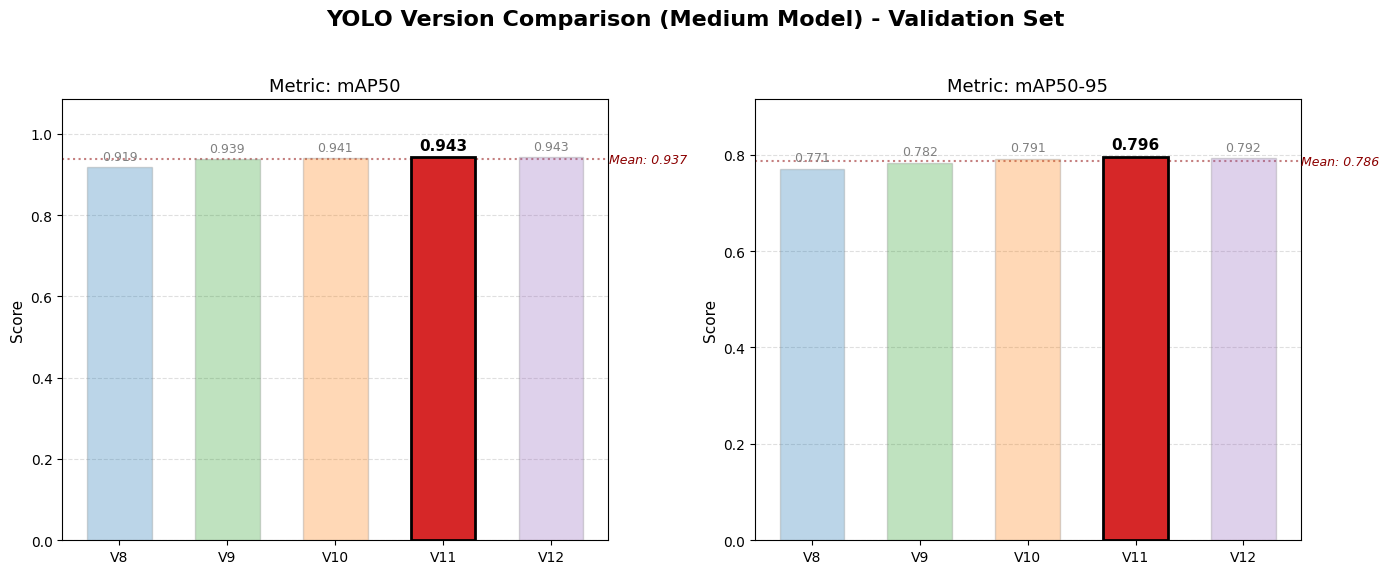

In [10]:
# --- 1. KONFIGURASI ---
# Path dasar project
base = Path("results/3class_without_augmentation")
fixed_size = "medium"

# Mapping Label Versi -> Nama File Model
version_map = {
    "v8":  "yolov8m.pt",
    "v9":  "yolov9m.pt",
    "v10": "yolov10m.pt",
    "v11": "yolo11m.pt",
    "v12": "yolo12m.pt"
}
variants = list(version_map.keys())

# Palet Warna
colors = {
    "v8":  "#1f77b4", # Biru
    "v9":  "#2ca02c", # Hijau
    "v10": "#ff7f0e", # Oranye
    "v11": "#d62728", # Merah
    "v12": "#9467bd", # Ungu
}

def load_metrics_from_csv(csv_path):
    """
    Membaca file class_metrics_validation.csv, mengambil baris 'all',
    dan mengembalikan mAP50 serta mAP50-95.
    """
    try:
        df = pd.read_csv(csv_path)
        # Bersihkan spasi pada nama kolom (jaga-jaga)
        df.columns = [c.strip() for c in df.columns]
        
        # Ambil baris dimana kolom 'class' == 'all'
        # Pastikan kolom 'class' ada
        if 'class' not in df.columns:
            raise ValueError("Kolom 'class' tidak ditemukan dalam CSV")
            
        row = df[df['class'] == 'all']
        
        if row.empty:
            raise ValueError("Baris dengan class='all' tidak ditemukan")
            
        # Ambil nilai (iloc[0] karena row masih berupa DataFrame satu baris)
        r = row.iloc[0]
        return float(r['mAP50']), float(r['mAP50-95'])
        
    except Exception as e:
        print(f"[ERR] Gagal membaca {csv_path}: {e}")
        return np.nan, np.nan

# --- 2. PERSIAPAN DATA ---
results_data = []

print("Loading Validation Data from 'class_metrics_validation.csv'...")

for variant_label in variants:
    model_filename = version_map[variant_label]
    
    # Konstruksi Path Baru:
    # results\3class_without_augmentation\validation\{model_name}-{size}\class_metrics_validation.csv
    folder_name = f"{model_filename}-{fixed_size}"
    csv_path = base / "validation" / folder_name / "class_metrics_validation.csv"
    
    row_data = {"variant": variant_label}
    
    if not csv_path.exists():
        print(f"[SKIP] File Missing: {csv_path}")
        row_data["mAP50"] = np.nan
        row_data["mAP50-95"] = np.nan
    else:
        # Load data menggunakan fungsi baru
        map50, map95 = load_metrics_from_csv(csv_path)
        row_data["mAP50"] = map50
        row_data["mAP50-95"] = map95
            
    results_data.append(row_data)

df = pd.DataFrame(results_data)

# --- 3. VISUALISASI ---
if df.empty or df['mAP50'].isnull().all():
    print("Tidak ada data valid untuk ditampilkan. Periksa path file Anda.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"YOLO Version Comparison ({fixed_size.capitalize()} Model) - Validation Set", fontsize=16, fontweight='bold')

    metrics = ["mAP50", "mAP50-95"]
    bar_w = 0.6 

    for ax, metric in zip(axes, metrics):
        # Cari nilai maksimum untuk highlight
        max_val = df[metric].max()
        
        # Loop manual per bar
        for i, row in df.iterrows():
            variant = row['variant']
            val = row[metric]
            
            if pd.isna(val): continue

            # Logic: Winner takes all highlighting
            is_best = np.isclose(val, max_val)
            
            # Style Definition
            if is_best:
                alpha = 1.0
                linewidth = 2.0
                edgecolor = 'black'
                zorder = 5
            else:
                alpha = 0.3 # Pudar
                linewidth = 1.0
                edgecolor = 'gray'
                zorder = 3

            # Plot Bar
            bar = ax.bar(
                variant.upper(), 
                val, 
                color=colors.get(variant, "gray"),
                edgecolor=edgecolor,
                linewidth=linewidth,
                alpha=alpha,
                width=bar_w,
                zorder=zorder
            )
            
            # Annotasi Text
            ax.text(
                bar[0].get_x() + bar[0].get_width()/2., 
                val + 0.01, 
                f'{val:.3f}',
                ha='center', 
                va='bottom', 
                fontsize=11 if is_best else 9,
                fontweight='bold' if is_best else 'normal',
                color='black' if is_best else 'gray'
            )

        # Estetika Grafik
        ax.set_title(f"Metric: {metric}", fontsize=13)
        ax.set_ylabel("Score", fontsize=11)
        
        # Atur batas Y
        if not pd.isna(max_val):
            ax.set_ylim(0, max_val * 1.15)
        
        # Grid
        ax.grid(axis="y", linestyle="--", alpha=0.4, zorder=0)

        # Garis Rata-rata
        mean_val = df[metric].mean()
        ax.axhline(mean_val, color='darkred', linestyle=':', alpha=0.5, zorder=1)
        ax.text(len(variants)-0.5, mean_val, f' Mean: {mean_val:.3f}', 
                va='center', fontsize=9, color='darkred', style='italic')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Training - best YOLO version (v11)

## Imgsz 640 - (nano, small, medium)

In [4]:
# Variabel Global
projectType = "yolo11_imgsz_640_comparison_experiment"
imgsz = 640
models = ['yolo11n.pt','yolo11s.pt','yolo11m.pt']
sizes = ['nano','small','medium']
epochs = 50
batch = 16
data_path_objectDetection_all_class = "dataset_collection/3class_without_augmentation"
project_base_objectDetection_all_class = "results/yolo11_imgsz_640_comparison_experiment"

In [5]:
mlflow.set_experiment(f"visiKomputerFundamental-{projectType}")
for model_name, size in zip(models, sizes):
    time_now = datetime.datetime.now().strftime("%d-%m_%H:%M:%S")
    model = YOLO(model_name)

    with mlflow.start_run(run_name=f"{time_now}"):

        # Log global parameters
        mlflow.log_params({
            "project type": projectType,
            "gpu": gpu_name,
            "epochs": epochs,
            "batch": batch,
            "imgsz": imgsz,
        })

        # Train the model
        start_time = time.time()
        training = model.train(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            epochs=epochs, 
            imgsz=imgsz, 
            batch=batch, 
            project=f"{project_base_objectDetection_all_class}/training", 
            name=f"{size}",
            exist_ok=True
        )
        end_time = time.time()

        # Validate the model
        validation = model.val(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            imgsz=imgsz,
            project=f"{project_base_objectDetection_all_class}/validation",
            name=f"{size}",
            exist_ok=True,
            split="test"
        )

        csv_filename = f"{project_base_objectDetection_all_class}/validation/summary/{size}-validation-metrics.csv"
        os.makedirs(os.path.dirname(csv_filename), exist_ok=True)
        with open(csv_filename, "w") as f:
            f.write(validation.to_csv())

        # Run validation + log class metrics
        mlflow.log_artifact(save_class_metrics(training, "training"), artifact_path="class_metrics")
        mlflow.log_artifact(save_class_metrics(validation, "validation"), artifact_path="class_metrics")

        # Log training time
        mlflow.log_params({
            "training time": format_duration(end_time - start_time),
        })

        mlflow.log_metrics({
            "val mAP50": float(validation.box.map50),
            "val mAP50-95": float(validation.box.map),
        })

        print(f"Finished training and validating {size} model.")

mlflow.end_run()

2026/01/02 19:53:42 INFO mlflow.tracking.fluent: Experiment with name 'visiKomputerFundamental-yolo11_imgsz_640_comparison_experiment' does not exist. Creating a new experiment.


New https://pypi.org/project/ultralytics/8.3.246 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.243  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_collection/3class_without_augmentation/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False

2026/01/02 19:54:06 INFO mlflow.tracking.fluent: Experiment with name 'results/yolo11_imgsz_640_comparison_experiment/training' does not exist. Creating a new experiment.


MLflow: logging run_id(4eadfd89c2a848b596a7cf75ebbc96b9) to https://dagshub.com/abiyamf/visiKomputerFundamental.mlflow
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\abiyamf\Documents\Code Program\TelU-Tubes-VisiKomputerFundamental-AnomaliDetection\results\yolo11_imgsz_640_comparison_experiment\training\nano
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      2.39G      1.871      5.082      1.026         10        640: 100% ━━━━━━━━━━━━ 46/46 1.7it/s 27.1s0.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.3it/s 2.3s0.5s
                   all         80        310    0.00227      0.117    0.00232   0.000909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.64G       1.44      2.869     0.8836          8  

Loading Training Data...


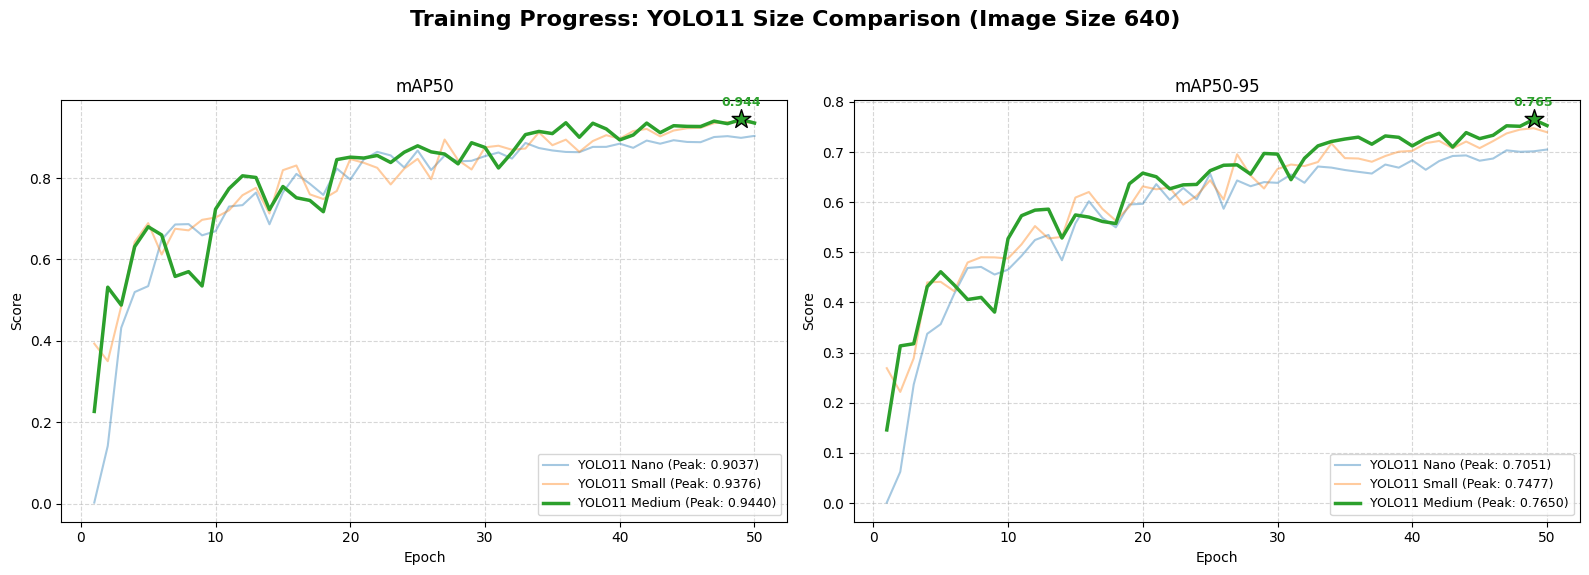

In [7]:
# --- 1. KONFIGURASI ---
base_path = Path("results/yolo11_imgsz_640_comparison_experiment")
training_path = base_path / "training"

sizes = ['nano', 'small', 'medium']

# Konfigurasi Visual
style_config = {
    "nano":   {"color": "#1f77b4", "label": "YOLO11 Nano"},   # Biru
    "small":  {"color": "#ff7f0e", "label": "YOLO11 Small"},  # Oranye
    "medium": {"color": "#2ca02c", "label": "YOLO11 Medium"}, # Hijau
}

metric_map = {
    "mAP50": "metrics/mAP50(B)",
    "mAP50-95": "metrics/mAP50-95(B)",
}

# --- 2. LOAD DATA ---
loaded_data = []
print("Loading Training Data...")

for size in sizes:
    csv_path = training_path / size / "results.csv"
    
    if not csv_path.exists():
        print(f"[SKIP] Missing: {csv_path}")
        continue
        
    try:
        df = pd.read_csv(csv_path)
        df.columns = [c.strip() for c in df.columns] # Bersihkan spasi
        
        # Ambil data max (peak)
        max_map50 = df[metric_map["mAP50"]].max()
        max_map95 = df[metric_map["mAP50-95"]].max()
        
        loaded_data.append({
            "size": size,
            "df": df,
            # PERBAIKAN: Gunakan nama key yang konsisten dengan metrics_list nanti
            "peak_mAP50": max_map50,
            "peak_mAP50-95": max_map95 
        })
    except Exception as e:
        print(f"[ERR] Error reading {csv_path}: {e}")

# --- 3. PLOTTING ---
if not loaded_data:
    print("Tidak ada data valid.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Training Progress: YOLO11 Size Comparison (Image Size 640)", fontsize=16, fontweight='bold')

    # List metric harus sama persis dengan akhiran key di loaded_data
    metrics_list = ["mAP50", "mAP50-95"]
    
    for idx, metric_key in enumerate(metrics_list):
        ax = axes[idx]
        col_name = metric_map[metric_key]
        
        # PERBAIKAN: Akses key secara langsung tanpa replace string
        best_run = max(loaded_data, key=lambda x: x[f"peak_{metric_key}"])
        best_size = best_run['size']
        
        for data in loaded_data:
            size = data['size']
            df = data['df']
            
            style = style_config.get(size, {"color": "gray", "label": size})
            is_winner = (size == best_size)
            
            # Setup Style (Winner vs Others)
            if is_winner:
                alpha = 1.0
                linewidth = 2.5
                zorder = 10
            else:
                alpha = 0.4
                linewidth = 1.5
                zorder = 2
            
            # Cari Titik Puncak (Peak) untuk model INI
            series = df[col_name]
            peak_val = series.max()
            peak_epoch = df.loc[series.idxmax(), 'epoch']
            
            label_txt = f"{style['label']} (Peak: {peak_val:.4f})"
            
            # Plot Garis
            ax.plot(df['epoch'], series, color=style['color'], label=label_txt,
                    linewidth=linewidth, alpha=alpha, zorder=zorder)
            
            # Highlight Puncak Pemenang dengan Bintang
            if is_winner:
                ax.scatter(peak_epoch, peak_val, color=style['color'], s=200, 
                           edgecolor='black', marker='*', zorder=11)
                # Anotasi
                ax.annotate(f"{peak_val:.3f}", (peak_epoch, peak_val),
                            xytext=(0, 10), textcoords='offset points',
                            ha='center', fontsize=9, fontweight='bold', color=style['color'])

        ax.set_title(metric_key, fontsize=12)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(loc="lower right", fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Loading Validation Summary Data...


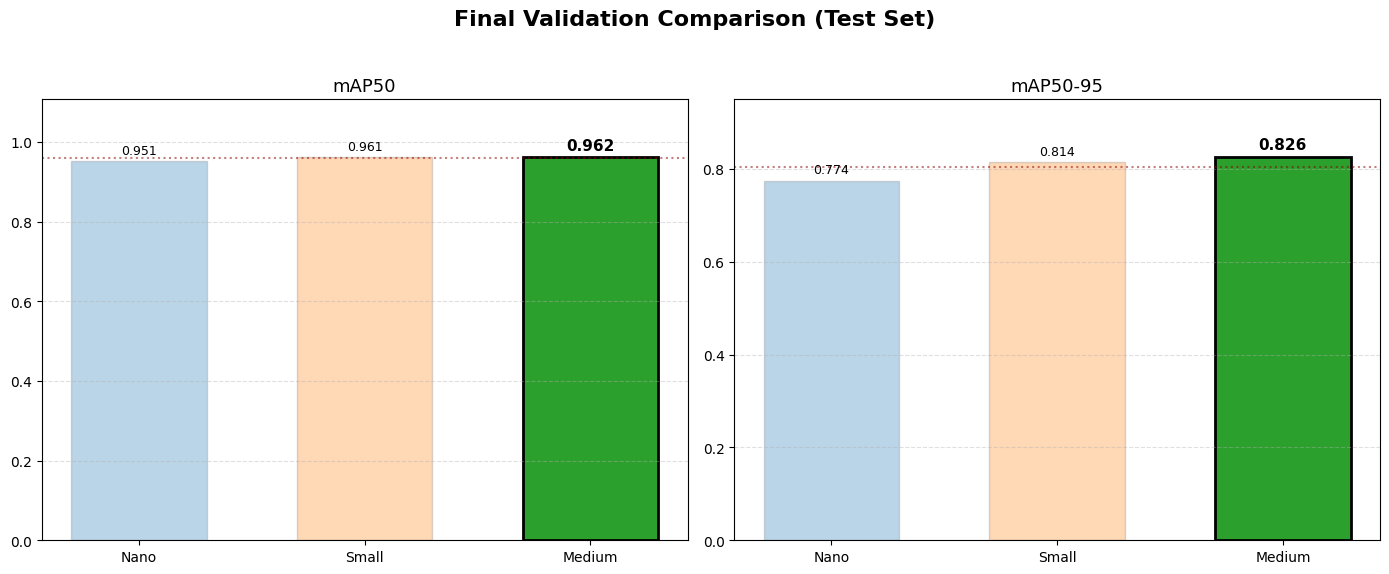

In [6]:
# --- 1. KONFIGURASI ---
base_path = Path("results/yolo11_imgsz_640_comparison_experiment")
val_summary_path = base_path / "validation" / "summary"

sizes = ['nano', 'small', 'medium']

colors = {
    "nano":   "#1f77b4", 
    "small":  "#ff7f0e", 
    "medium": "#2ca02c", 
}

# --- 2. LOAD DATA ---
results_data = []
print("Loading Validation Summary Data...")

for size in sizes:
    # Path sesuai code training: summary/{size}-validation-metrics.csv
    csv_path = val_summary_path / f"{size}-validation-metrics.csv"
    
    row_data = {"variant": size}
    
    if not csv_path.exists():
        print(f"[SKIP] Missing: {csv_path}")
        row_data["mAP50"] = np.nan
        row_data["mAP50-95"] = np.nan
    else:
        try:
            # Baca CSV hasil to_csv() dari ultralytics
            df = pd.read_csv(csv_path)
            df.columns = [c.strip() for c in df.columns]
            
            # Cari baris 'all' (biasanya di kolom pertama yg mungkin bernama index atau class)
            # Kita cari kolom yang berisi string 'all'
            found = False
            for col in df.columns:
                if df[col].astype(str).str.contains('all').any():
                    row = df[df[col] == 'all'].iloc[0]
                    
                    # Ambil Metrics (Ultralytics keys)
                    # Mapping key kadang metrics/mAP50(B) atau map50
                    m50 = row.get('metrics/mAP50(B)', row.get('map50', row.get('mAP50', np.nan)))
                    m95 = row.get('metrics/mAP50-95(B)', row.get('map50-95', row.get('mAP50-95', np.nan)))
                    
                    row_data["mAP50"] = float(m50)
                    row_data["mAP50-95"] = float(m95)
                    found = True
                    break
            
            if not found:
                # Fallback: Ambil baris pertama jika format berbeda (biasanya summary ada di top)
                row = df.iloc[0]
                m50 = row.get('metrics/mAP50(B)', row.get('map50', row.get('mAP50', np.nan)))
                m95 = row.get('metrics/mAP50-95(B)', row.get('map50-95', row.get('mAP50-95', np.nan)))
                row_data["mAP50"] = float(m50)
                row_data["mAP50-95"] = float(m95)

        except Exception as e:
            print(f"[ERR] Error reading {csv_path}: {e}")
            row_data["mAP50"] = np.nan
            row_data["mAP50-95"] = np.nan
            
    results_data.append(row_data)

df_val = pd.DataFrame(results_data)

# --- 3. PLOTTING BAR CHART ---
if df_val.empty or df_val['mAP50'].isnull().all():
    print("Tidak ada data valid.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Final Validation Comparison (Test Set)", fontsize=16, fontweight='bold')

    metrics = ["mAP50", "mAP50-95"]
    bar_w = 0.6

    for ax, metric in zip(axes, metrics):
        # Cari Max Value untuk Highlight
        max_val = df_val[metric].max()
        
        for i, row in df_val.iterrows():
            variant = row['variant']
            val = row[metric]
            
            if pd.isna(val): continue
            
            is_best = np.isclose(val, max_val)
            
            # Style: Highlight Best
            if is_best:
                alpha = 1.0
                linewidth = 2.0
                edgecolor = 'black'
            else:
                alpha = 0.3
                linewidth = 1.0
                edgecolor = 'gray'
            
            bar = ax.bar(variant.capitalize(), val, color=colors.get(variant, 'gray'),
                         width=bar_w, alpha=alpha, linewidth=linewidth, edgecolor=edgecolor)
            
            # Anotasi Nilai
            ax.text(bar[0].get_x() + bar[0].get_width()/2., val + 0.01,
                    f"{val:.3f}", ha='center', va='bottom',
                    fontsize=11 if is_best else 9, fontweight='bold' if is_best else 'normal')

        ax.set_title(metric, fontsize=13)
        ax.set_ylim(0, max_val * 1.15)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        
        # Garis Rata-rata
        mean_val = df_val[metric].mean()
        ax.axhline(mean_val, color='darkred', linestyle=':', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Imgsz 1024 - (nano, small, medium)

In [ ]:
# Variabel Global
projectType = "yolo11_imgsz_1024_comparison_experiment"
imgsz = 1024
models = ['yolo11n.pt','yolo11s.pt','yolo11m.pt']
sizes = ['nano','small','medium']
epochs = 50
batch = 16
data_path_objectDetection_all_class = "dataset_collection/3class_without_augmentation"
project_base_objectDetection_all_class = "results/yolo11_imgsz_1024_comparison_experiment"

In [5]:
mlflow.set_experiment(f"visiKomputerFundamental-{projectType}")
for model_name, size in zip(models, sizes):
    time_now = datetime.datetime.now().strftime("%d-%m_%H:%M:%S")
    model = YOLO(model_name)

    with mlflow.start_run(run_name=f"{time_now}"):

        # Log global parameters
        mlflow.log_params({
            "project type": projectType,
            "gpu": gpu_name,
            "epochs": epochs,
            "batch": batch,
            "imgsz": imgsz,
        })

        # Train the model
        start_time = time.time()
        training = model.train(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            epochs=epochs, 
            imgsz=imgsz, 
            batch=batch, 
            project=f"{project_base_objectDetection_all_class}/training", 
            name=f"{size}",
            exist_ok=True
        )
        end_time = time.time()

        # Validate the model
        validation = model.val(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            imgsz=imgsz,
            project=f"{project_base_objectDetection_all_class}/validation",
            name=f"{size}",
            exist_ok=True,
            split="test"
        )

        csv_filename = f"{project_base_objectDetection_all_class}/validation/summary/{size}-validation-metrics.csv"
        os.makedirs(os.path.dirname(csv_filename), exist_ok=True)
        with open(csv_filename, "w") as f:
            f.write(validation.to_csv())

        # Run validation + log class metrics
        mlflow.log_artifact(save_class_metrics(training, "training"), artifact_path="class_metrics")
        mlflow.log_artifact(save_class_metrics(validation, "validation"), artifact_path="class_metrics")

        # Log training time
        mlflow.log_params({
            "training time": format_duration(end_time - start_time),
        })

        mlflow.log_metrics({
            "val mAP50": float(validation.box.map50),
            "val mAP50-95": float(validation.box.map),
        })

        print(f"Finished training and validating {size} model.")

mlflow.end_run()

New https://pypi.org/project/ultralytics/8.3.246 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.243  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_collection/3class_without_augmentation/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False

Loading Training Data...


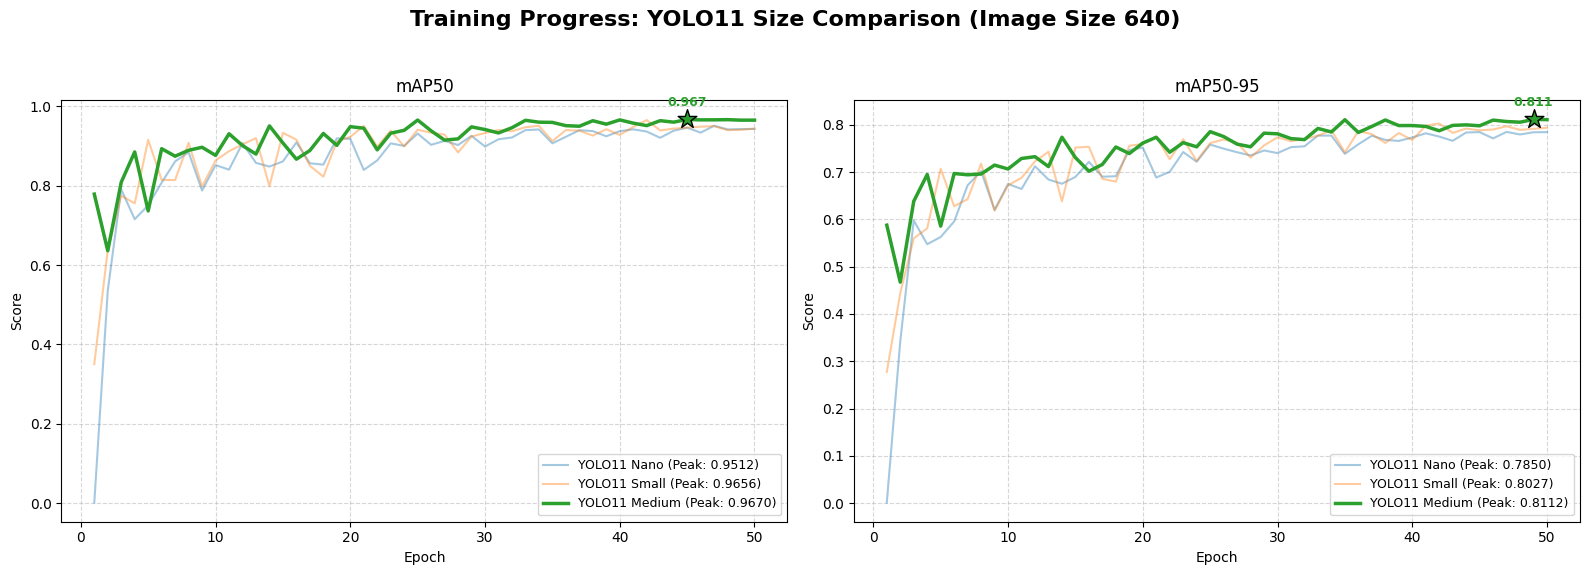

In [6]:
# --- 1. KONFIGURASI ---
base_path = Path("results/yolo11_imgsz_1024_comparison_experiment")
training_path = base_path / "training"

sizes = ['nano', 'small', 'medium']

# Konfigurasi Visual
style_config = {
    "nano":   {"color": "#1f77b4", "label": "YOLO11 Nano"},   # Biru
    "small":  {"color": "#ff7f0e", "label": "YOLO11 Small"},  # Oranye
    "medium": {"color": "#2ca02c", "label": "YOLO11 Medium"}, # Hijau
}

metric_map = {
    "mAP50": "metrics/mAP50(B)",
    "mAP50-95": "metrics/mAP50-95(B)",
}

# --- 2. LOAD DATA ---
loaded_data = []
print("Loading Training Data...")

for size in sizes:
    csv_path = training_path / size / "results.csv"
    
    if not csv_path.exists():
        print(f"[SKIP] Missing: {csv_path}")
        continue
        
    try:
        df = pd.read_csv(csv_path)
        df.columns = [c.strip() for c in df.columns] # Bersihkan spasi
        
        # Ambil data max (peak)
        max_map50 = df[metric_map["mAP50"]].max()
        max_map95 = df[metric_map["mAP50-95"]].max()
        
        loaded_data.append({
            "size": size,
            "df": df,
            # PERBAIKAN: Gunakan nama key yang konsisten dengan metrics_list nanti
            "peak_mAP50": max_map50,
            "peak_mAP50-95": max_map95 
        })
    except Exception as e:
        print(f"[ERR] Error reading {csv_path}: {e}")

# --- 3. PLOTTING ---
if not loaded_data:
    print("Tidak ada data valid.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Training Progress: YOLO11 Size Comparison (Image Size 640)", fontsize=16, fontweight='bold')

    # List metric harus sama persis dengan akhiran key di loaded_data
    metrics_list = ["mAP50", "mAP50-95"]
    
    for idx, metric_key in enumerate(metrics_list):
        ax = axes[idx]
        col_name = metric_map[metric_key]
        
        # PERBAIKAN: Akses key secara langsung tanpa replace string
        best_run = max(loaded_data, key=lambda x: x[f"peak_{metric_key}"])
        best_size = best_run['size']
        
        for data in loaded_data:
            size = data['size']
            df = data['df']
            
            style = style_config.get(size, {"color": "gray", "label": size})
            is_winner = (size == best_size)
            
            # Setup Style (Winner vs Others)
            if is_winner:
                alpha = 1.0
                linewidth = 2.5
                zorder = 10
            else:
                alpha = 0.4
                linewidth = 1.5
                zorder = 2
            
            # Cari Titik Puncak (Peak) untuk model INI
            series = df[col_name]
            peak_val = series.max()
            peak_epoch = df.loc[series.idxmax(), 'epoch']
            
            label_txt = f"{style['label']} (Peak: {peak_val:.4f})"
            
            # Plot Garis
            ax.plot(df['epoch'], series, color=style['color'], label=label_txt,
                    linewidth=linewidth, alpha=alpha, zorder=zorder)
            
            # Highlight Puncak Pemenang dengan Bintang
            if is_winner:
                ax.scatter(peak_epoch, peak_val, color=style['color'], s=200, 
                           edgecolor='black', marker='*', zorder=11)
                # Anotasi
                ax.annotate(f"{peak_val:.3f}", (peak_epoch, peak_val),
                            xytext=(0, 10), textcoords='offset points',
                            ha='center', fontsize=9, fontweight='bold', color=style['color'])

        ax.set_title(metric_key, fontsize=12)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(loc="lower right", fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Loading Validation Summary Data...


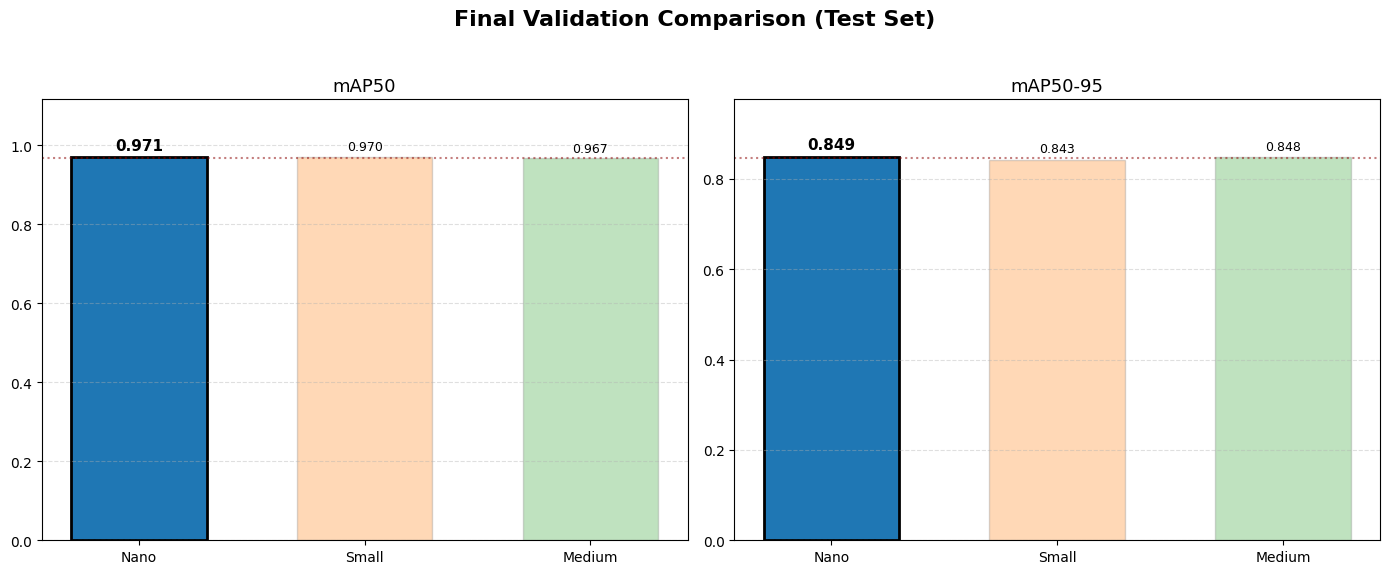

In [7]:
# --- 1. KONFIGURASI ---
base_path = Path("results/yolo11_imgsz_1024_comparison_experiment")
val_summary_path = base_path / "validation" / "summary"

sizes = ['nano', 'small', 'medium']

colors = {
    "nano":   "#1f77b4", 
    "small":  "#ff7f0e", 
    "medium": "#2ca02c", 
}

# --- 2. LOAD DATA ---
results_data = []
print("Loading Validation Summary Data...")

for size in sizes:
    # Path sesuai code training: summary/{size}-validation-metrics.csv
    csv_path = val_summary_path / f"{size}-validation-metrics.csv"
    
    row_data = {"variant": size}
    
    if not csv_path.exists():
        print(f"[SKIP] Missing: {csv_path}")
        row_data["mAP50"] = np.nan
        row_data["mAP50-95"] = np.nan
    else:
        try:
            # Baca CSV hasil to_csv() dari ultralytics
            df = pd.read_csv(csv_path)
            df.columns = [c.strip() for c in df.columns]
            
            # Cari baris 'all' (biasanya di kolom pertama yg mungkin bernama index atau class)
            # Kita cari kolom yang berisi string 'all'
            found = False
            for col in df.columns:
                if df[col].astype(str).str.contains('all').any():
                    row = df[df[col] == 'all'].iloc[0]
                    
                    # Ambil Metrics (Ultralytics keys)
                    # Mapping key kadang metrics/mAP50(B) atau map50
                    m50 = row.get('metrics/mAP50(B)', row.get('map50', row.get('mAP50', np.nan)))
                    m95 = row.get('metrics/mAP50-95(B)', row.get('map50-95', row.get('mAP50-95', np.nan)))
                    
                    row_data["mAP50"] = float(m50)
                    row_data["mAP50-95"] = float(m95)
                    found = True
                    break
            
            if not found:
                # Fallback: Ambil baris pertama jika format berbeda (biasanya summary ada di top)
                row = df.iloc[0]
                m50 = row.get('metrics/mAP50(B)', row.get('map50', row.get('mAP50', np.nan)))
                m95 = row.get('metrics/mAP50-95(B)', row.get('map50-95', row.get('mAP50-95', np.nan)))
                row_data["mAP50"] = float(m50)
                row_data["mAP50-95"] = float(m95)

        except Exception as e:
            print(f"[ERR] Error reading {csv_path}: {e}")
            row_data["mAP50"] = np.nan
            row_data["mAP50-95"] = np.nan
            
    results_data.append(row_data)

df_val = pd.DataFrame(results_data)

# --- 3. PLOTTING BAR CHART ---
if df_val.empty or df_val['mAP50'].isnull().all():
    print("Tidak ada data valid.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Final Validation Comparison (Test Set)", fontsize=16, fontweight='bold')

    metrics = ["mAP50", "mAP50-95"]
    bar_w = 0.6

    for ax, metric in zip(axes, metrics):
        # Cari Max Value untuk Highlight
        max_val = df_val[metric].max()
        
        for i, row in df_val.iterrows():
            variant = row['variant']
            val = row[metric]
            
            if pd.isna(val): continue
            
            is_best = np.isclose(val, max_val)
            
            # Style: Highlight Best
            if is_best:
                alpha = 1.0
                linewidth = 2.0
                edgecolor = 'black'
            else:
                alpha = 0.3
                linewidth = 1.0
                edgecolor = 'gray'
            
            bar = ax.bar(variant.capitalize(), val, color=colors.get(variant, 'gray'),
                         width=bar_w, alpha=alpha, linewidth=linewidth, edgecolor=edgecolor)
            
            # Anotasi Nilai
            ax.text(bar[0].get_x() + bar[0].get_width()/2., val + 0.01,
                    f"{val:.3f}", ha='center', va='bottom',
                    fontsize=11 if is_best else 9, fontweight='bold' if is_best else 'normal')

        ax.set_title(metric, fontsize=13)
        ax.set_ylim(0, max_val * 1.15)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        
        # Garis Rata-rata
        mean_val = df_val[metric].mean()
        ax.axhline(mean_val, color='darkred', linestyle=':', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Imgsz terbaik dilatih menggunakan data augmentation

In [ ]:
# Variabel Global
projectType = "yolo11_imgsz_1024_augmentation_experiment"
imgsz = 1024
models = ['yolo11n.pt','yolo11s.pt','yolo11m.pt']
sizes = ['nano','small','medium']
epochs = 50
batch = 16
data_path_objectDetection_all_class = "dataset_collection/3class_augmentation_brightness_rotation_flip"
project_base_objectDetection_all_class = "results/yolo11_imgsz_1024_augmentation_experiment"

In [5]:
mlflow.set_experiment(f"visiKomputerFundamental-{projectType}")
for model_name, size in zip(models, sizes):
    time_now = datetime.datetime.now().strftime("%d-%m_%H:%M:%S")
    model = YOLO(model_name)

    with mlflow.start_run(run_name=f"{time_now}"):

        # Log global parameters
        mlflow.log_params({
            "project type": projectType,
            "gpu": gpu_name,
            "epochs": epochs,
            "batch": batch,
            "imgsz": imgsz,
        })

        # Train the model
        start_time = time.time()
        training = model.train(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            epochs=epochs, 
            imgsz=imgsz, 
            batch=batch, 
            project=f"{project_base_objectDetection_all_class}/training", 
            name=f"{size}",
            exist_ok=True
        )
        end_time = time.time()

        # Validate the model
        validation = model.val(
            data=f"{data_path_objectDetection_all_class}/data.yaml", 
            imgsz=imgsz,
            project=f"{project_base_objectDetection_all_class}/validation",
            name=f"{size}",
            exist_ok=True,
            split="test"
        )

        csv_filename = f"{project_base_objectDetection_all_class}/validation/summary/{size}-validation-metrics.csv"
        os.makedirs(os.path.dirname(csv_filename), exist_ok=True)
        with open(csv_filename, "w") as f:
            f.write(validation.to_csv())

        # Run validation + log class metrics
        mlflow.log_artifact(save_class_metrics(training, "training"), artifact_path="class_metrics")
        mlflow.log_artifact(save_class_metrics(validation, "validation"), artifact_path="class_metrics")

        # Log training time
        mlflow.log_params({
            "training time": format_duration(end_time - start_time),
        })

        mlflow.log_metrics({
            "val mAP50": float(validation.box.map50),
            "val mAP50-95": float(validation.box.map),
        })

        print(f"Finished training and validating {size} model.")

mlflow.end_run()

New https://pypi.org/project/ultralytics/8.3.246 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.243  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_collection/3class_augmentation_brightness_rotation_flip/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, 

### Graph perbandingan apakah augmentation meningkatkan mAP validation atau tidak

Loading Data Comparison (No Aug vs With Aug)...


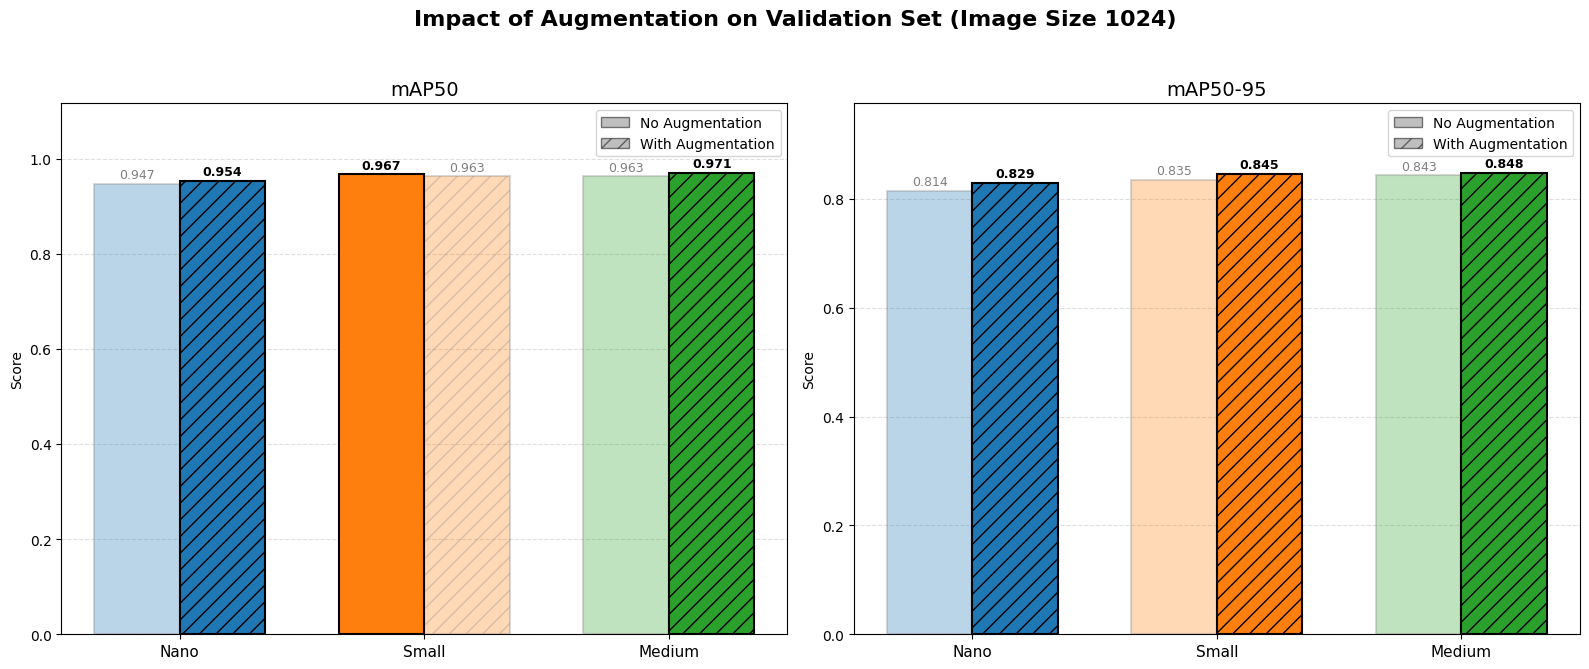

In [8]:
# --- 1. KONFIGURASI PATH ---
# Path Eksperimen 1: No Augmentation
PATH_NO_AUG = Path("results/yolo11_imgsz_1024_comparison_experiment")

# Path Eksperimen 2: With Augmentation
PATH_WITH_AUG = Path("results/yolo11_imgsz_1024_augmentation_experiment")

SIZES = ['nano', 'small', 'medium']

# Palet Warna per Ukuran Model
COLORS = {
    "nano":   "#1f77b4", # Biru
    "small":  "#ff7f0e", # Oranye
    "medium": "#2ca02c", # Hijau
}

# Fungsi Helper Baca CSV
def get_metrics_from_csv(base_project_path, size):
    # Konstruksi Path sesuai request:
    # results\{project_name}\validation\{size}\class_metrics_validation.csv
    csv_path = base_project_path / "validation" / size / "class_metrics_validation.csv"
    
    if not csv_path.exists():
        print(f"[SKIP] Missing: {csv_path}")
        return np.nan, np.nan
    
    try:
        df = pd.read_csv(csv_path)
        # Bersihkan spasi nama kolom
        df.columns = [c.strip() for c in df.columns]
        
        # Cari baris dengan class == 'all'
        if 'class' not in df.columns:
             print(f"[ERR] Kolom 'class' tidak ada di {csv_path}")
             return np.nan, np.nan

        row = df[df['class'] == 'all']
        
        if row.empty:
            print(f"[ERR] Baris 'all' tidak ditemukan di {csv_path}")
            return np.nan, np.nan
            
        r = row.iloc[0]
        
        # Ambil nilai mAP
        m50 = float(r['mAP50'])
        m95 = float(r['mAP50-95'])
        
        return m50, m95

    except Exception as e:
        print(f"[ERR] Error reading {csv_path}: {e}")
        return np.nan, np.nan

# --- 2. LOAD DATA ---
data_comparison = []

print("Loading Data Comparison (No Aug vs With Aug)...")

for size in SIZES:
    # Ambil data No Aug
    no_aug_m50, no_aug_m95 = get_metrics_from_csv(PATH_NO_AUG, size)
    
    # Ambil data With Aug
    aug_m50, aug_m95 = get_metrics_from_csv(PATH_WITH_AUG, size)
    
    data_comparison.append({
        "size": size,
        "No Aug": {"mAP50": no_aug_m50, "mAP50-95": no_aug_m95},
        "With Aug": {"mAP50": aug_m50, "mAP50-95": aug_m95}
    })

# --- 3. VISUALISASI ---
# Cek apakah ada data valid sebelum plotting
valid_data = any(not pd.isna(d['No Aug']['mAP50']) for d in data_comparison)
if not valid_data:
    print("Tidak ada data valid yang ditemukan.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle("Impact of Augmentation on Validation Set (Image Size 1024)", fontsize=16, fontweight='bold')

    metrics_keys = ["mAP50", "mAP50-95"]
    bar_width = 0.35
    x = np.arange(len(SIZES))

    for idx, metric in enumerate(metrics_keys):
        ax = axes[idx]
        
        # Loop per size (Nano, Small, Medium)
        for i, item in enumerate(data_comparison):
            size_name = item['size']
            base_color = COLORS.get(size_name, 'gray')
            
            val_no_aug = item['No Aug'][metric]
            val_with_aug = item['With Aug'][metric]
            
            # Tentukan Pemenang per Size
            if pd.isna(val_no_aug) or pd.isna(val_with_aug):
                max_val = -1
            else:
                max_val = max(val_no_aug, val_with_aug)
            
            # --- Plot Bar No Aug (Kiri) ---
            is_best_no = np.isclose(val_no_aug, max_val) if not pd.isna(val_no_aug) else False
            alpha_no = 1.0 if is_best_no else 0.3
            edge_no = 'black' if is_best_no else 'gray'
            z_no = 5 if is_best_no else 3
            
            bar1 = ax.bar(x[i] - bar_width/2, val_no_aug, width=bar_width, 
                          color=base_color, alpha=alpha_no, edgecolor=edge_no, linewidth=1.5,
                          label="No Augmentation" if i == 0 else "", hatch="", zorder=z_no)
            
            # Annotasi No Aug
            ax.text(bar1[0].get_x() + bar1[0].get_width()/2., val_no_aug + 0.005,
                    f"{val_no_aug:.3f}", ha='center', va='bottom', fontsize=9, 
                    fontweight='bold' if is_best_no else 'normal', color='black' if is_best_no else 'gray')

            # --- Plot Bar With Aug (Kanan) ---
            is_best_aug = np.isclose(val_with_aug, max_val) if not pd.isna(val_with_aug) else False
            alpha_aug = 1.0 if is_best_aug else 0.3
            edge_aug = 'black' if is_best_aug else 'gray'
            z_aug = 5 if is_best_aug else 3
            
            # Hatching '//' untuk membedakan visual Augmentation
            bar2 = ax.bar(x[i] + bar_width/2, val_with_aug, width=bar_width, 
                          color=base_color, alpha=alpha_aug, edgecolor=edge_aug, linewidth=1.5,
                          label="With Augmentation" if i == 0 else "", hatch="//", zorder=z_aug)
            
            # Annotasi With Aug
            ax.text(bar2[0].get_x() + bar2[0].get_width()/2., val_with_aug + 0.005,
                    f"{val_with_aug:.3f}", ha='center', va='bottom', fontsize=9,
                    fontweight='bold' if is_best_aug else 'normal', color='black' if is_best_aug else 'gray')

        # Kosmetik Grafik
        ax.set_title(metric, fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels([s.capitalize() for s in SIZES], fontsize=11)
        ax.set_ylabel("Score")
        
        # Legend Custom
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='gray', edgecolor='black', alpha=0.5, label='No Augmentation'),
            Patch(facecolor='gray', edgecolor='black', alpha=0.5, hatch='//', label='With Augmentation')
        ]
        ax.legend(handles=legend_elements, loc='best', fontsize=10)
        
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        
        # Y Limit Dinamis
        vals = [d['No Aug'][metric] for d in data_comparison] + [d['With Aug'][metric] for d in data_comparison]
        valid_vals = [v for v in vals if not pd.isna(v)]
        max_v = max(valid_vals) if valid_vals else 1.0
        ax.set_ylim(0, max_v * 1.15)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Model predict

In [ ]:
# Melakukan predict ke subset test untuk visualisasi laporan

# Object counting

In [2]:
import numpy as np
import supervision as sv

from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

In [3]:
def process_video_counting(source_path, target_path, model_path):
    """
    Memproses video untuk mendeteksi, tracking, dan menghitung objek yang melewati garis tengah vertikal.
    """
    
    # 1. Load Model dan Video Info
    model = YOLO(model_path)
    video_info = sv.VideoInfo.from_video_path(source_path)
    
    # 2. Setup Line Zone (Vertikal dari atas ke bawah, posisi di tengah)
    # Menggunakan width // 2 agar otomatis di tengah berapapun resolusinya
    START = sv.Point(video_info.width // 2, 0) 
    END = sv.Point(video_info.width // 2, video_info.height)

    line_zone = sv.LineZone(start=START, end=END)

    # 3. Inisialisasi Tracker dan Annotators
    byte_tracker = sv.ByteTrack()

    box_annotator = sv.BoxAnnotator(thickness=4)
    label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
    trace_annotator = sv.TraceAnnotator(thickness=4)
    
    line_zone_annotator = sv.LineZoneAnnotator(
        thickness=4,
        text_thickness=4,
        text_scale=2,
        display_in_count=False, # Sesuai kode asli Anda
        custom_out_text="defect coffee beans"
    )

    # 4. Definisi Callback Function untuk pemrosesan per frame
    def callback(frame: np.ndarray, index: int) -> np.ndarray:
        # Inference
        results = model(frame, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        
        # Tracking
        detections = byte_tracker.update_with_detections(detections)

        # Labeling (Tracking ID + Class Name + Confidence)
        labels = [
            f"#{tracker_id} {model.names[class_id]} {confidence:0.2f}"
            for confidence, class_id, tracker_id
            in zip(detections.confidence, detections.class_id, detections.tracker_id)
        ]

        # Annotasi Visual
        annotated_frame = frame.copy()
        
        # Gambar Jejak (Trace)
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame,
            detections=detections
        )
        
        # Gambar Kotak (Box)
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=detections
        )
        
        # Gambar Label
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels
        )

        # Update Line Counter
        line_zone.trigger(detections)

        # Gambar Garis dan Counter
        return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

    # 5. Jalankan Pemrosesan Video
    print(f"Processing video: {source_path}...")
    sv.process_video(
        source_path=source_path,
        target_path=target_path,
        callback=callback
    )
    print(f"Done! Saved to: {target_path}")

In [4]:
SOURCE_VIDEO = "video_conveyor/video_conveyor_speed_normal.mp4"
OUTPUT_VIDEO = "video_output/video_conveyor_speed_normal.mp4"
MODEL_PATH = "results/yolo11_imgsz_1024_augmentation_experiment/training/nano/weights/best.pt"

process_video_counting(SOURCE_VIDEO, OUTPUT_VIDEO, MODEL_PATH)

Processing video: video_conveyor/video_conveyor_speed_normal.mp4...
Done! Saved to: video_output/video_conveyor_speed_normal.mp4


In [7]:
SOURCE_VIDEO = "video_conveyor/video_conveyor_speed_up.mp4"
OUTPUT_VIDEO = "video_output/video_conveyor_speed_up.mp4"
MODEL_PATH = "results/yolo11_imgsz_1024_augmentation_experiment/training/nano/weights/best.pt"

process_video_counting(SOURCE_VIDEO, OUTPUT_VIDEO, MODEL_PATH)

Processing video: video_conveyor/video_conveyor_speed_up.mp4...
Done! Saved to: video_output/video_conveyor_speed_up.mp4
